### Bi-LSTM model - binary training

#### Environment preparation

In [1]:
# Montowanie Google Drive
from google.colab import drive
drive.mount('/content/drive')

COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
print(f"Dane będą wczytywane z: {COLAB_ROOT}")

Mounted at /content/drive
Dane będą wczytywane z: /content/drive/MyDrive/PainRecognitionProject/


In [2]:
import os

# Przejście do katalogu głównego
%cd /content

# Klonowanie repo
!rm -rf automatic-pain-recognition

print(f"Obecne położenie: {os.getcwd()}")

/content
Obecne położenie: /content


In [3]:
# Upewnij się, że nazwa użytkownika i repozytorium są poprawne
USERNAME = 'alicka33'
REPO_NAME = 'automatic-pain-recognition'

# Tworzenie poprawnego adresu URL (format: https://<TOKEN>@github.com/...)
REPO_URL = f"https://github.com/{USERNAME}/{REPO_NAME}.git"

print("Rozpoczynam klonowanie...")

# Klonowanie
!git clone {REPO_URL}

# Wejście do katalogu
%cd $REPO_NAME

Rozpoczynam klonowanie...
Cloning into 'automatic-pain-recognition'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 321 (delta 24), reused 34 (delta 14), pack-reused 277 (from 1)
Receiving objects: 100% (321/321), 11.99 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (148/148), done.
/content/automatic-pain-recognition


In [4]:
# Instalacja wymaganych bibliotek
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [5]:
import sys
import os

# Dodaj katalog główny projektu do ścieżki systemowej
sys.path.append(os.getcwd())
print(f"Dodano do ścieżki Pythona: {os.getcwd()}")

Dodano do ścieżki Pythona: /content/automatic-pain-recognition


#### Bi-LSTM model - binary training

In [6]:
import os
import numpy as np
import pandas as pd
import shutil

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from training_utils.preprocessed_dataset import PreprocessedDataset
from training_utils.train import Trainer
from training_utils.evaluate import Evaluator
from models.Bi_LSTM import SequenceModel

#### Hiperparameters

In [7]:
MAX_SEQUENCE_LENGTH = 46
NUM_FEATURES = 300
NUM_CLASSES = 2
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_EPOCHS = 200
BATCH_SIZE = 16
LEARNING_RATE = 0.00005
DROPOUT_PROB = 0.3
WEIGHT_DECAY = 0.005
SCHEDULER_FACTOR = 0.9

#### Data preparation

In [8]:
COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
PROCESSED_DATA_DIR = os.path.join(COLAB_ROOT, 'data/BioVid_HeatPain_processed_478_xyz_frontalized/')
MODEL_SAVE_DIR = os.path.join(COLAB_ROOT, 'models/')
LOCAL_PROCESSED_DATA_ROOT = '/content/temp_data/'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
print("Kopiowanie danych z Google Drive do lokalnej pamięci Colab (RAM)...")
if os.path.exists(LOCAL_PROCESSED_DATA_ROOT):
    shutil.rmtree(LOCAL_PROCESSED_DATA_ROOT)
try:
    shutil.copytree(PROCESSED_DATA_DIR, LOCAL_PROCESSED_DATA_ROOT)
    print("✅ Kopiowanie zakończone pomyślnie. Czas trwania: (sprawdź zegar)")
    CURRENT_DATA_DIR = LOCAL_PROCESSED_DATA_ROOT

except Exception as e:
    print(f"❌ Błąd kopiowania danych (sprawdź, czy dane są zamontowane): {e}")
    print("Używam danych bezpośrednio z Drive (może się zawiesić).")
    CURRENT_DATA_DIR = PROCESSED_DATA_DIR

Kopiowanie danych z Google Drive do lokalnej pamięci Colab (RAM)...
✅ Kopiowanie zakończone pomyślnie. Czas trwania: (sprawdź zegar)


In [10]:
best100 = np.load('/content/drive/MyDrive/PainRecognitionProject/data/top_100_important_landmarks_emotions.npy')

In [10]:
best_100_landmarks = np.load('/content/drive/MyDrive/PainRecognitionProject/data/top_100_important_landmarks_emotions.npy')

feature_indices_x = best_100_landmarks * 3
feature_indices_y = best_100_landmarks * 3 + 1
feature_indices_z = best_100_landmarks * 3 + 2

# Interleave to get [X1, Y1, Z1, X2, Y2, Z2, ...]
best_300_features = np.stack([feature_indices_x, feature_indices_y, feature_indices_z], axis=1).flatten()


In [11]:
train_dataset = PreprocessedDataset(
    'train',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_300_features,
    compute_euclidean=False,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[0, 4],
    label_map={0: 0, 4: 1},
)

val_dataset = PreprocessedDataset(
    'val',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_300_features,
    compute_euclidean=False,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[0, 4],
    label_map={0: 0, 4: 1},
)

test_dataset = PreprocessedDataset(
    'test',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_300_features,
    compute_euclidean=False,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[0, 4],
    label_map={0: 0, 4: 1},
)

In [12]:
def preview_single(dataset, idx=0, timesteps_to_show=3, features_to_show=8):
    x, y = dataset[idx]
    print(f"\nSingle sample idx={idx} from split={dataset.dataset_name}")
    print(f"x shape: {tuple(x.shape)}, y: {y}")
    print(np.round(x[:timesteps_to_show, :features_to_show], 4))

preview_single(train_dataset, 0)
preview_single(val_dataset, 0)
preview_single(test_dataset, 0)


Single sample idx=0 from split=train
x shape: (46, 300), y: 0
tensor([[0.1507, 0.1288, 0.1142, 0.1074, 0.2043, 0.0947, 0.1404, 0.0928],
        [0.1488, 0.1293, 0.1180, 0.1079, 0.2146, 0.1028, 0.1382, 0.0917],
        [0.1507, 0.1252, 0.1187, 0.1093, 0.2105, 0.1028, 0.1401, 0.0886]])

Single sample idx=0 from split=val
x shape: (46, 300), y: 0
tensor([[0.1483, 0.1156, 0.1151, 0.1027, 0.1887, 0.0901, 0.1374, 0.0823],
        [0.1522, 0.1143, 0.1157, 0.1043, 0.1852, 0.0900, 0.1415, 0.0816],
        [0.1524, 0.1143, 0.1155, 0.1045, 0.1854, 0.0897, 0.1416, 0.0817]])

Single sample idx=0 from split=test
x shape: (46, 300), y: 0
tensor([[0.1401, 0.1400, 0.1036, 0.0984, 0.2080, 0.0833, 0.1307, 0.1012],
        [0.1392, 0.1376, 0.1043, 0.0974, 0.2055, 0.0839, 0.1297, 0.0993],
        [0.1393, 0.1381, 0.1052, 0.0976, 0.2081, 0.0852, 0.1300, 0.0995]])


In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in train_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in val_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in test_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

torch.Size([16, 46, 300]) torch.Size([16])
torch.Size([16, 46, 300]) torch.Size([16])
torch.Size([16, 46, 300]) torch.Size([16])


#### Model preparation

In [14]:
model = SequenceModel(NUM_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, DROPOUT_PROB).to(DEVICE)

#### Training

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=SCHEDULER_FACTOR,
    patience=10,
    min_lr=1e-7
)

model_name = 'testing_new_code_bi_lstm_2_classes_300_coord.pt'
model_filepath = os.path.join(MODEL_SAVE_DIR, model_name)

saprawdzic jak teraz działa ten scheduler !!!!

In [16]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=DEVICE,
    model_save_path=model_filepath,
    num_epochs=NUM_EPOCHS,
    monitor='val_acc',  # or 'val_loss'
    minimize_monitor=False,
    save_best_only=True
)

In [17]:
trainer.print_training_config()



🚀 TRAINING CONFIGURATION

--- Model Architecture ---
  Model Type            : SequenceModel
  Input Features        : 300
  Hidden Size           : 128
  Num Layers            : 2
  Bidirectional         : True
  Dropout (LSTM)        : 0.3
  Num Parameters        : 836098

--- Optimizer & Regularization ---
  Optimizer             : AdamW
  Learning Rate (LR)    : 5e-05
  Weight Decay (L2)     : 0.005

--- Training Flow ---
  Batch Size            : 16
  Num Epochs            : 200
  Device                : cuda



In [18]:
final_model_path, best_model_path, history = trainer.fit()
print(f"Final model saved to: {final_model_path}")
if best_model_path:
    print(f"Best model saved to: {best_model_path}")


Starting training for 200 epochs on cuda
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_bi_lstm_2_classes_300_coord.pt (metric=0.5000)
Epoch 1/200 | Time 6.73s | Train loss 0.6934 | Train acc 0.4959 | Val loss 0.6930 | Val acc 0.5000
Epoch 2/200 | Time 2.79s | Train loss 0.6939 | Train acc 0.4992 | Val loss 0.6932 | Val acc 0.5000
Epoch 3/200 | Time 2.43s | Train loss 0.6937 | Train acc 0.5070 | Val loss 0.6932 | Val acc 0.5000
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_bi_lstm_2_classes_300_coord.pt (metric=0.5173)
Epoch 4/200 | Time 2.87s | Train loss 0.6930 | Train acc 0.5102 | Val loss 0.6926 | Val acc 0.5173
Epoch 5/200 | Time 2.82s | Train loss 0.6928 | Train acc 0.5139 | Val loss 0.6931 | Val acc 0.5000
Epoch 6/200 | Time 2.49s | Train loss 0.6931 | Train acc 0.4959 | Val loss 0.6924 | Val acc 0.5173
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_tes

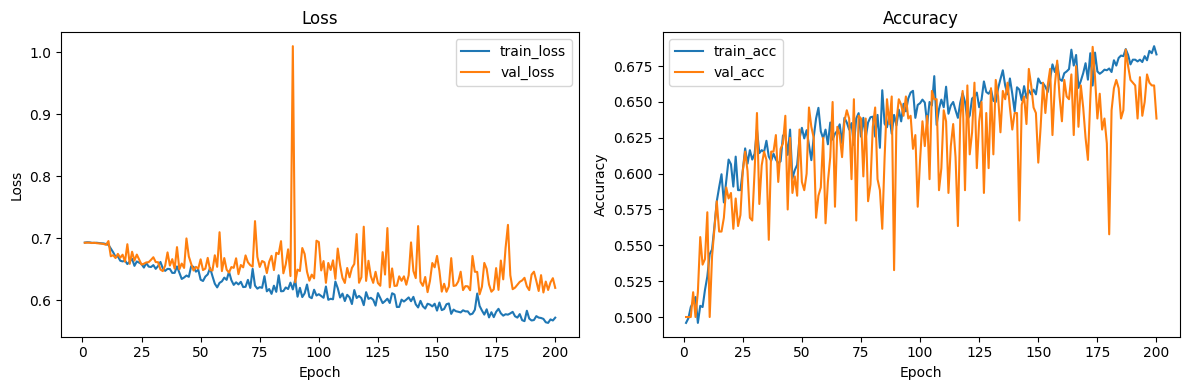

In [19]:
trainer.plot_history()

#### Evaluate

In [20]:
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE), strict=False)

<All keys matched successfully>

In [21]:
evaluator = Evaluator(model, test_loader, device=DEVICE, model_name=model_name, num_classes=NUM_CLASSES)


In [22]:
loss, acc, labels, preds = evaluator.evaluate_epoch()


WYNIKI OCENY DLA MODELU: testing_new_code_bi_lstm_2_classes_300_coord.pt
Test Loss: 0.5137
Test Accuracy: 0.7096

--- Szczegółowy Raport Klasyfikacji ---
              precision    recall  f1-score   support

     Klasa 0       0.67      0.82      0.74       260
     Klasa 1       0.77      0.60      0.68       260

    accuracy                           0.71       520
   macro avg       0.72      0.71      0.71       520
weighted avg       0.72      0.71      0.71       520

Confusion matrix:
 [[212  48]
 [103 157]]
